In [1]:
#import mplpub
import numpy as np
from ase import Atoms
from ase.io import read
from ase.spacegroup.symmetrize import FixSymmetry
from ase.units import GPa, kB
from calorine.calculators import CPUNEP
from calorine.tools import get_force_constants, relax_structure
from matplotlib import pyplot as plt, colormaps
from pandas import DataFrame, read_json, concat as pd_concat
from phonopy import load, Phonopy, PhonopyQHA
from phonopy.structure.atoms import PhonopyAtoms
from phonopy.units import Avogadro, EvTokJmol, kb_J, THzToEv
from seekpath import get_explicit_k_path
from tqdm import tqdm

R = kb_J * Avogadro
#mplpub.setup(template='acs')

In [2]:
def get_structure(phonon):
    structure_ph = phonon.primitive
    structure_ase = Atoms(symbols=structure_ph.symbols, cell=structure_ph.cell,
                          scaled_positions=structure_ph.scaled_positions, pbc=True)
    return structure_ase

In [3]:
def labels_to_latex(labels_in):
    labels = [r'$\UG{\Gamma}$' if m == 'GAMMA' else m for m in labels_in]
    labels = [m.replace('SIGMA', r'$\UG{\Sigma}$') if m.startswith('SIGMA') else m for m in labels]
    labels = [m.replace('_', '$_') + '$' if '_' in m else m for m in labels]
    return labels 

In [4]:
colors = {
    'BaZrS3-spg140-I4mcm': 'C0',
    'BaZrS3-spg62-Pnma': 'C1',
    'BaZrS3-spg221-Pm3m': 'C2',
}

labels = {
    'BaZrS3-spg140-I4mcm': 'I4/mcm',
    'BaZrS3-spg62-Pnma': 'Pnma',
    'BaZrS3-spg221-Pm3m': 'Pm-3m',
}

In [5]:
xc = 'HSE'
model_filename = 'nep.txt'
supercell_matrix = [4, 4, 4]

phonons = {}
for sname in labels:
    print(f'sname: {sname}')
    phonons[sname] = {}
    for volsc in tqdm(np.arange(0.92, 1.11, 0.01)):
        volsc = np.around(volsc, decimals=3)
        outfile = f'runs-{xc}/phonon-{sname}-volsc{volsc:.3f}.yaml'
        try:
            ph = load(outfile)
        except:
            structure = read(f'{sname}.xyz')
            cell = structure.cell[:] * volsc ** (1 / 3)
            structure.set_cell(cell, scale_atoms=True)
            calculator = CPUNEP(model_filename)
            structure.calc = calculator
            structure.set_constraint(FixSymmetry(structure))
            relax_structure(structure, constant_volume=True)
            ph = get_force_constants(structure, calculator, supercell_matrix=supercell_matrix)
            ph.save(outfile)

        phonons[sname][volsc] = ph

sname: BaZrS3-spg140-I4mcm


100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


sname: BaZrS3-spg62-Pnma


100%|██████████| 20/20 [00:24<00:00,  1.23s/it]


sname: BaZrS3-spg221-Pm3m


100%|██████████| 20/20 [00:13<00:00,  1.46it/s]


# Pnma

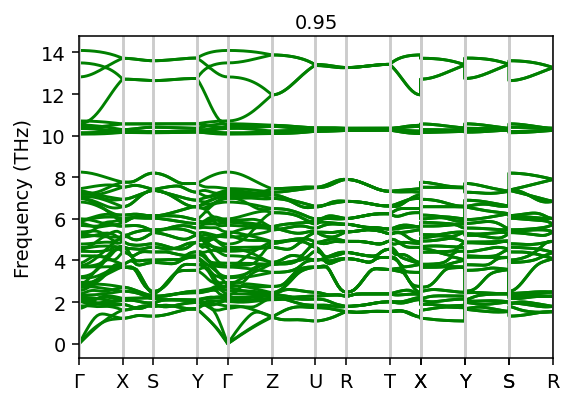

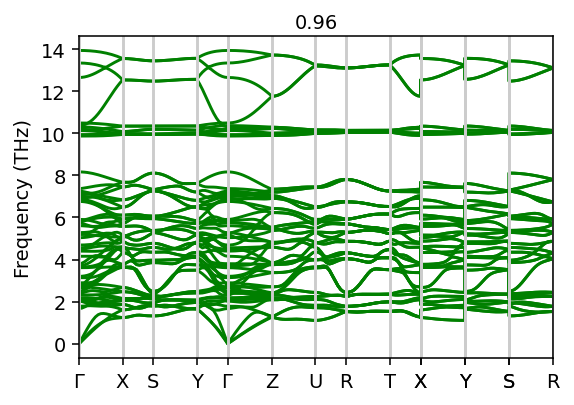

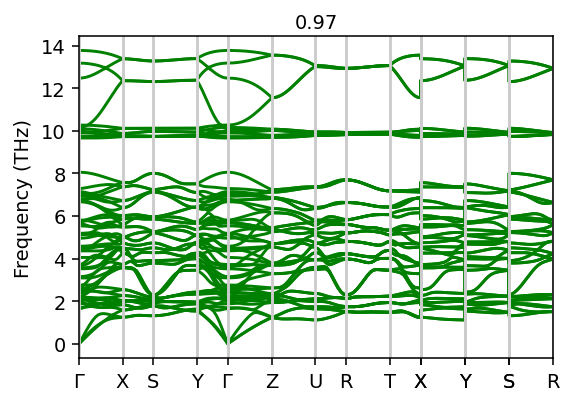

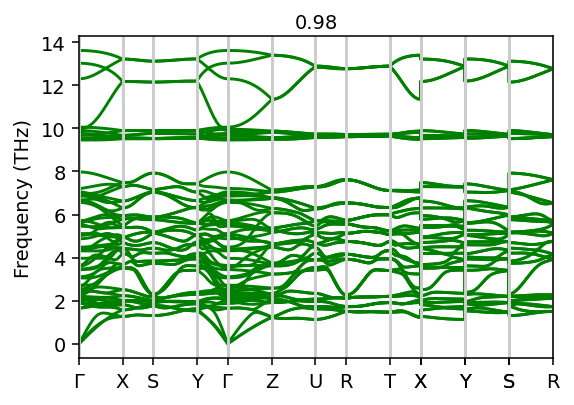

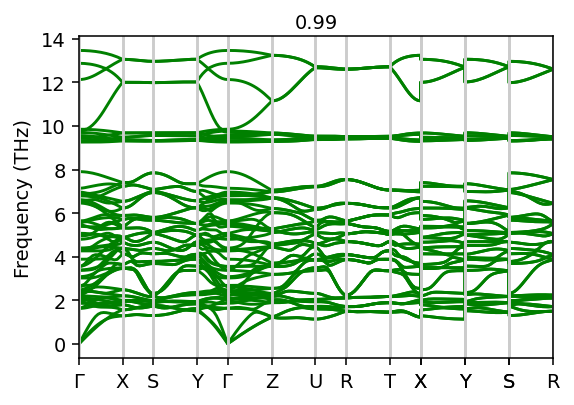

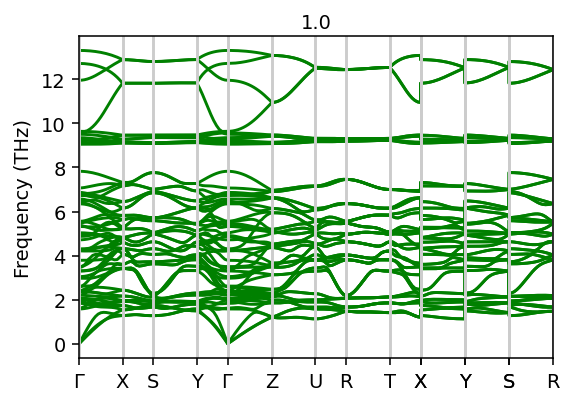

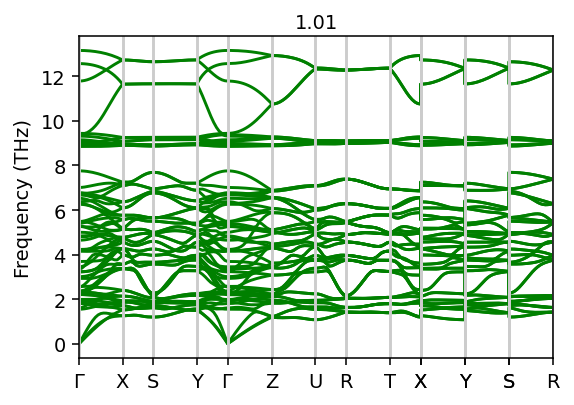

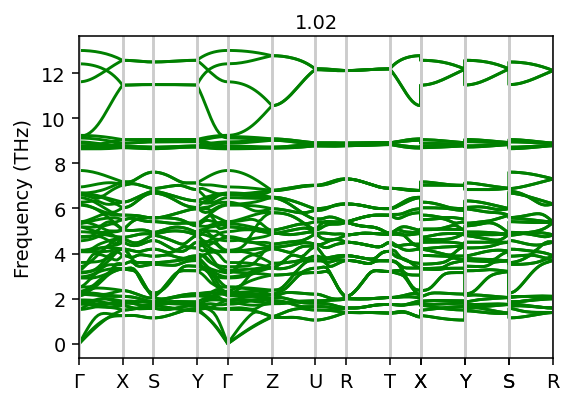

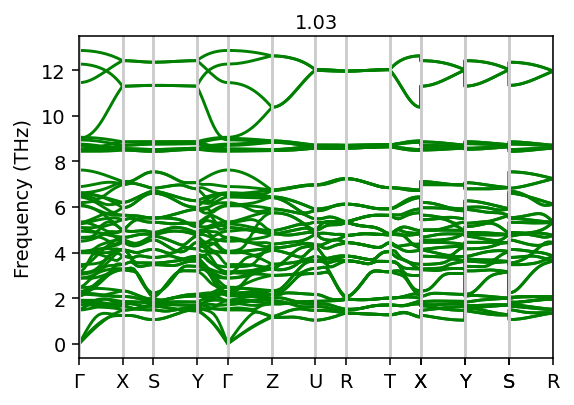

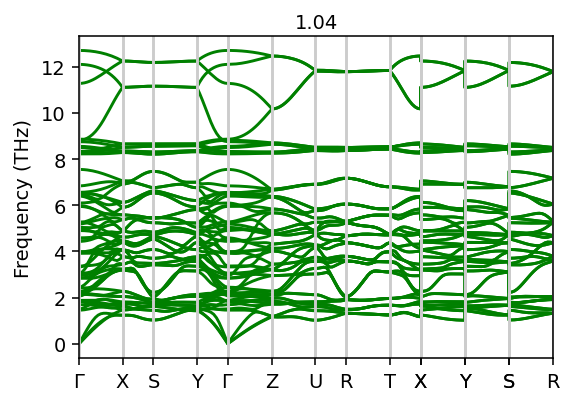

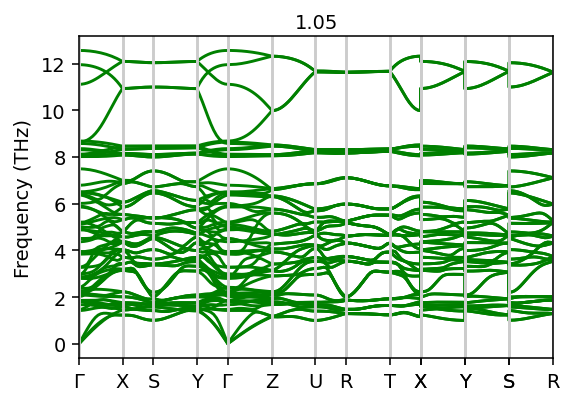

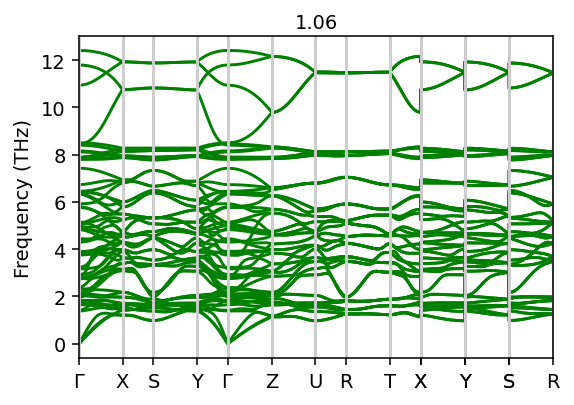

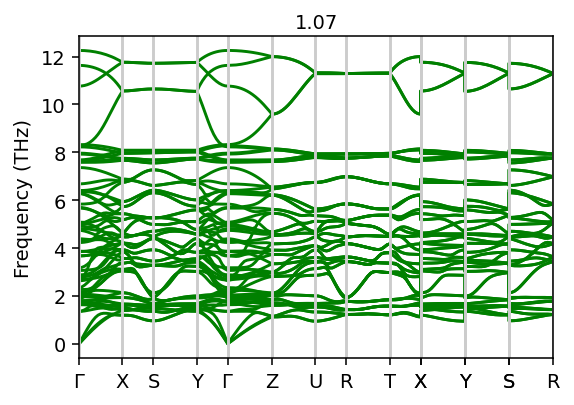

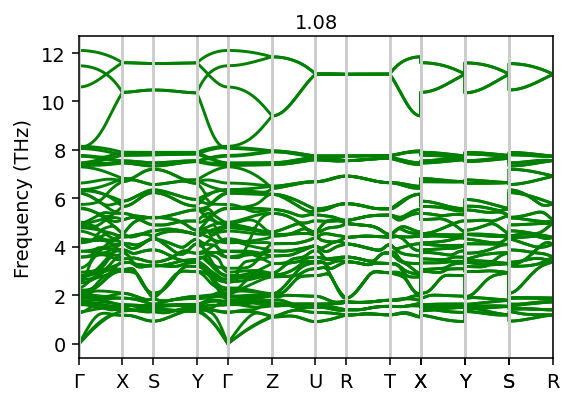

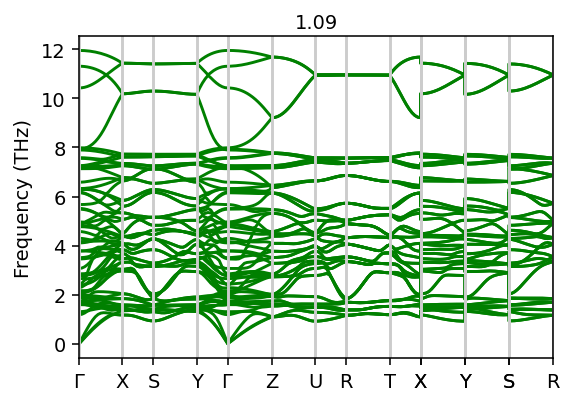

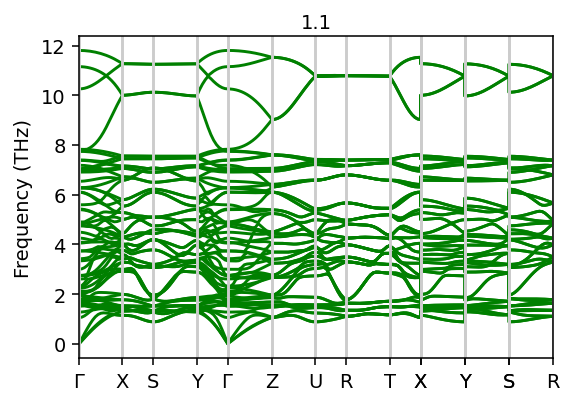

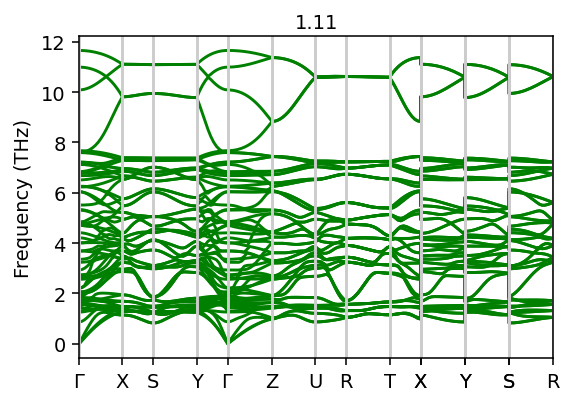

In [8]:
for volsc in np.arange(0.95, 1.11, 0.01):
    phonon = phonons['BaZrS3-spg62-Pnma'][volsc]
    structure = get_structure(phonon)
    structure_tuple = (structure.cell[:], structure.get_scaled_positions(), structure.numbers)
    path = get_explicit_k_path(structure_tuple)
    phonon.run_band_structure([path['explicit_kpoints_rel']])
    band = phonon.get_band_structure_dict()
    df = DataFrame(band['frequencies'][0])
    df.index = path['explicit_kpoints_linearcoord']
    fig, ax = plt.subplots(figsize=(4.2, 3), dpi=140)

    for col in df.columns:
        ax.plot(df.index, df[col], color='green')
    ax.set_xlim(df.index.min(), df.index.max())
    ax.set_xlabel(volsc)
    ax.xaxis.set_label_position('top')
    ax.set_ylabel('Frequency (THz)')

# beautify the labels on the x-axis
    labels = path['explicit_kpoints_labels']
    labels = ['$\Gamma$' if m == 'GAMMA' else m for m in labels]
    labels = [m.replace('_', '$_') + '$' if '_' in m else m for m in labels]
    df_path = DataFrame(dict(labels=labels,
                         positions=path['explicit_kpoints_linearcoord']))
    df_path.drop(df_path.index[df_path.labels == ''], axis=0, inplace=True)
    ax.set_xticks(df_path.positions)
    ax.set_xticklabels(df_path.labels)
    for xp in df_path.positions:
        ax.axvline(xp, color='0.8')
    plt.tight_layout()


# I4/mcm

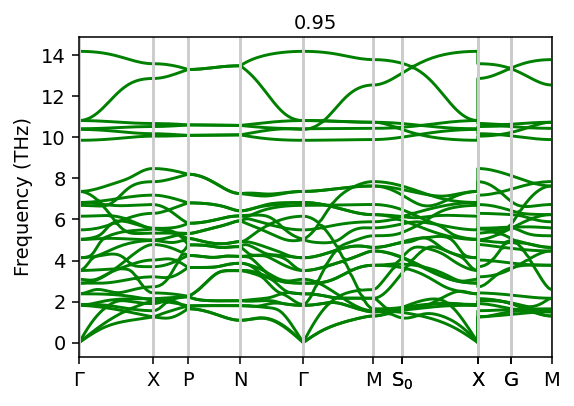

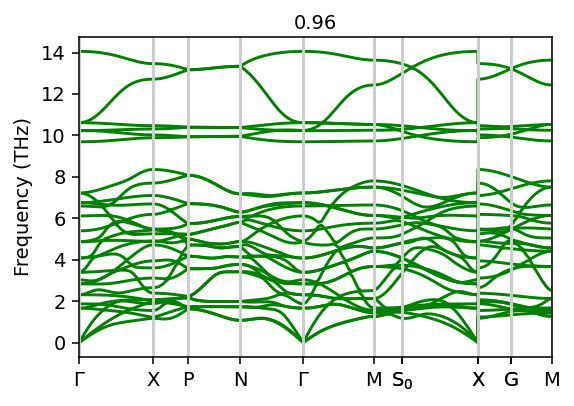

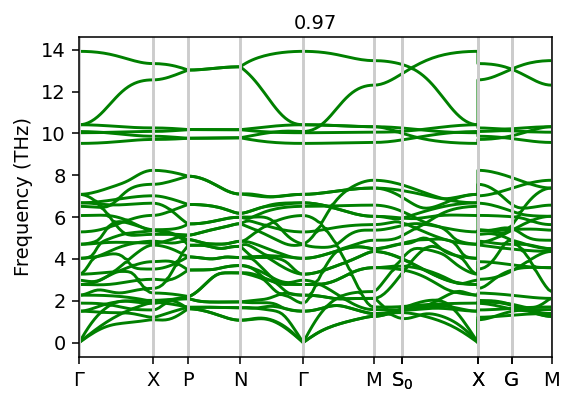

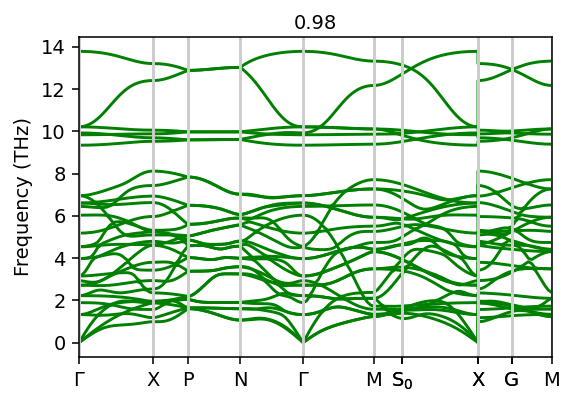

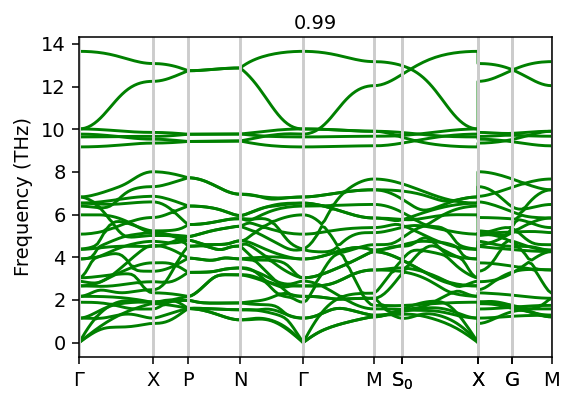

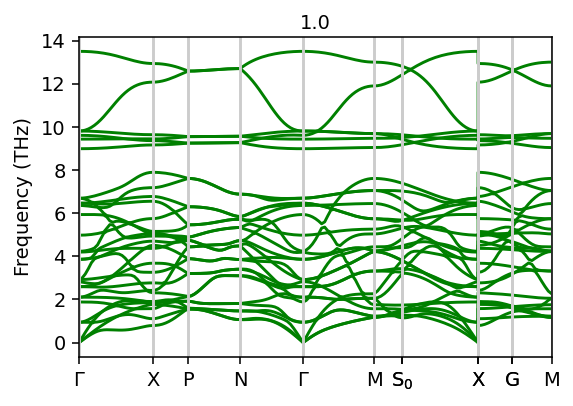

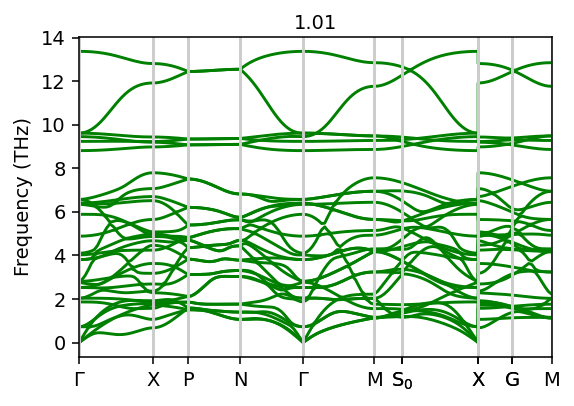

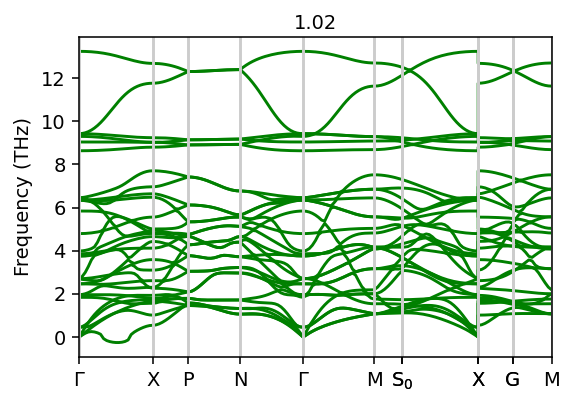

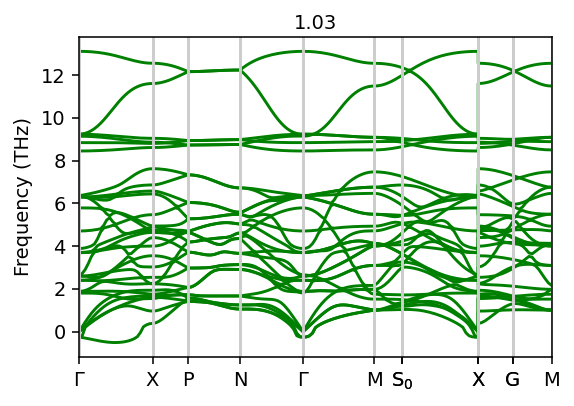

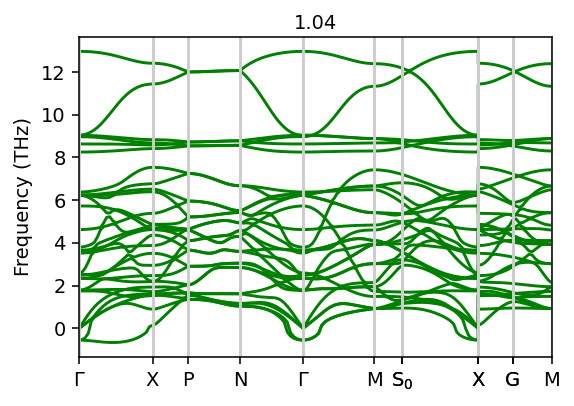

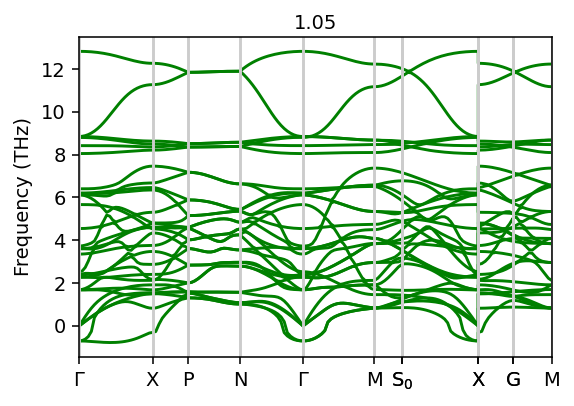

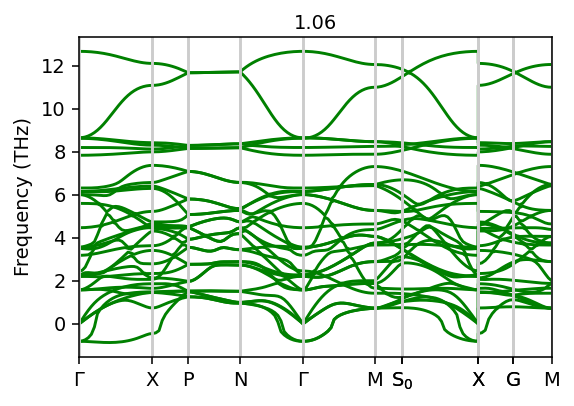

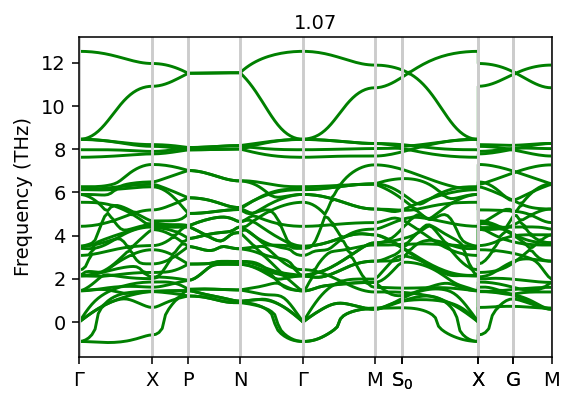

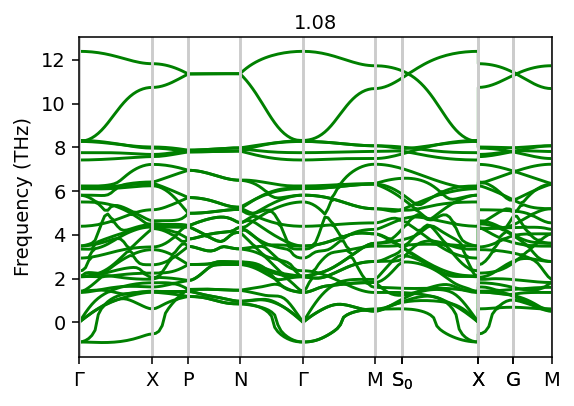

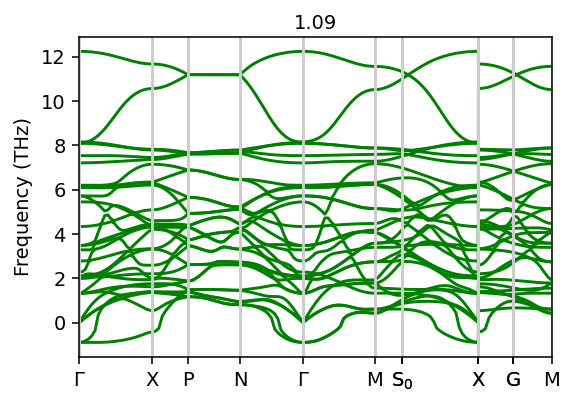

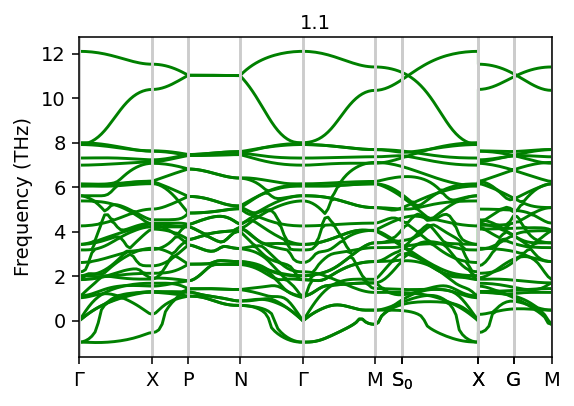

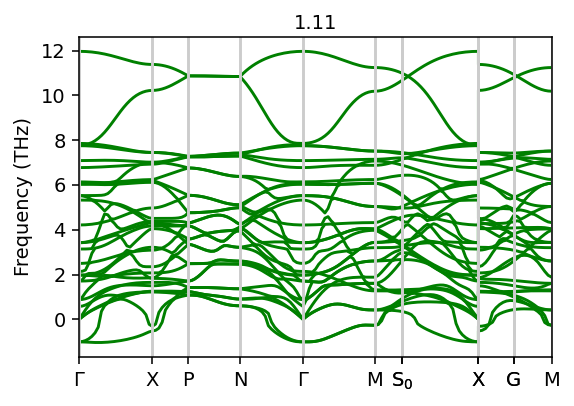

In [10]:
for volsc in np.arange(0.95, 1.11, 0.01):
    phonon = phonons['BaZrS3-spg140-I4mcm'][volsc]
    structure = get_structure(phonon)
    structure_tuple = (structure.cell[:], structure.get_scaled_positions(), structure.numbers)
    path = get_explicit_k_path(structure_tuple)
    phonon.run_band_structure([path['explicit_kpoints_rel']])
    band = phonon.get_band_structure_dict()
    df = DataFrame(band['frequencies'][0])
    df.index = path['explicit_kpoints_linearcoord']
    fig, ax = plt.subplots(figsize=(4.2, 3), dpi=140)

    for col in df.columns:
        ax.plot(df.index, df[col], color='green')
    ax.set_xlim(df.index.min(), df.index.max())
    ax.set_xlabel(volsc)
    ax.xaxis.set_label_position('top')
    ax.set_ylabel('Frequency (THz)')

# beautify the labels on the x-axis
    labels = path['explicit_kpoints_labels']
    labels = ['$\Gamma$' if m == 'GAMMA' else m for m in labels]
    labels = [m.replace('_', '$_') + '$' if '_' in m else m for m in labels]
    df_path = DataFrame(dict(labels=labels,
                         positions=path['explicit_kpoints_linearcoord']))
    df_path.drop(df_path.index[df_path.labels == ''], axis=0, inplace=True)
    ax.set_xticks(df_path.positions)
    ax.set_xticklabels(df_path.labels)
    for xp in df_path.positions:
        ax.axvline(xp, color='0.8')
    plt.tight_layout()

# Pm-3m

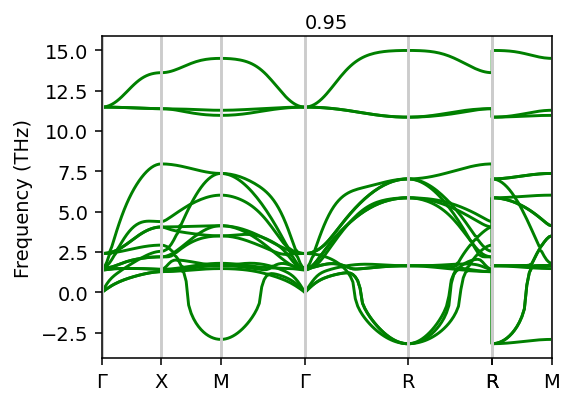

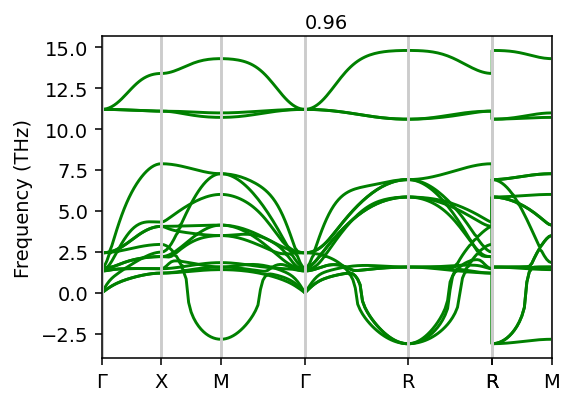

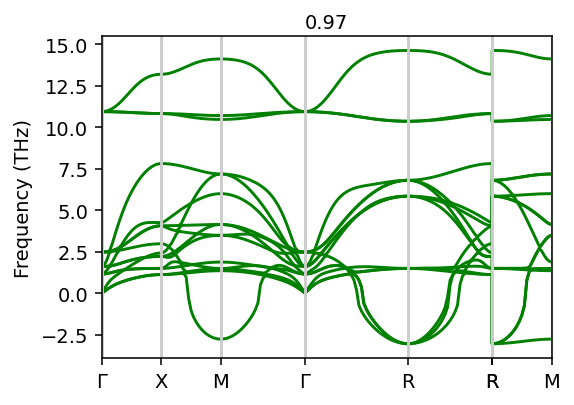

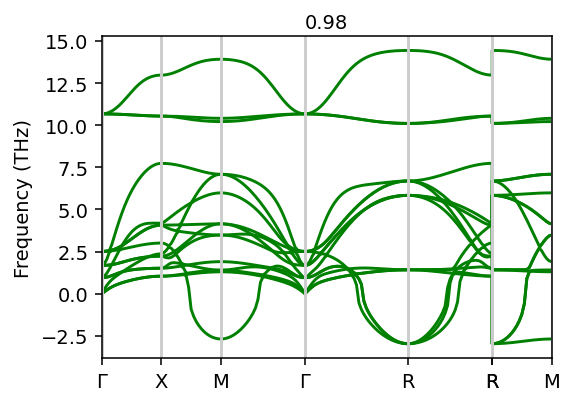

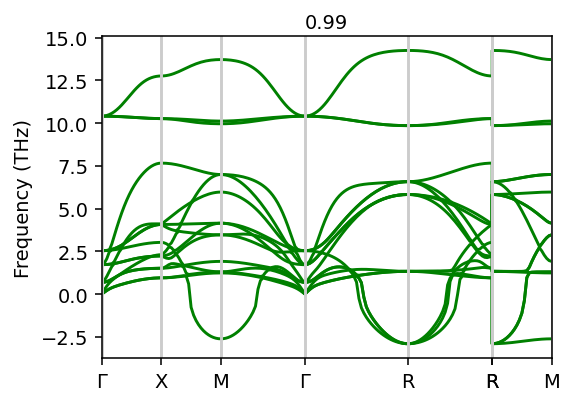

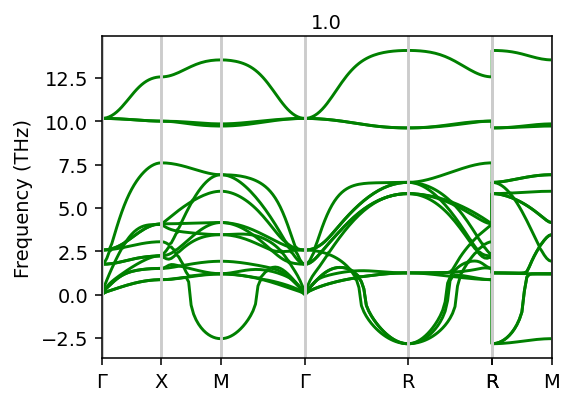

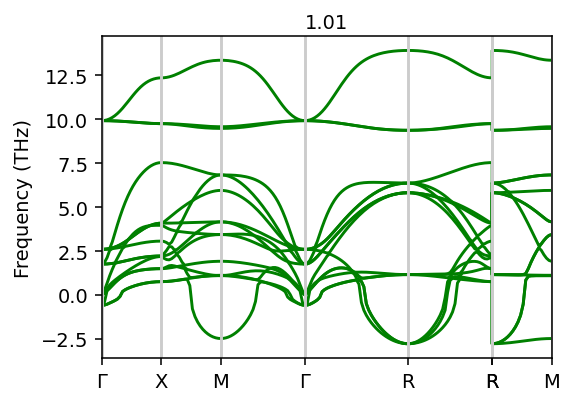

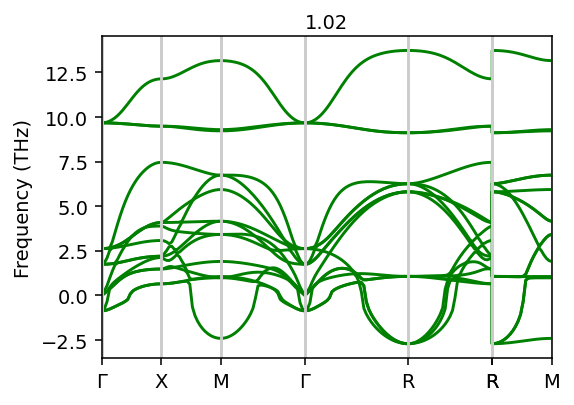

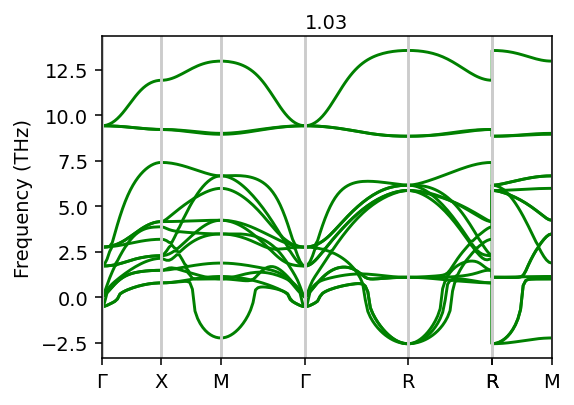

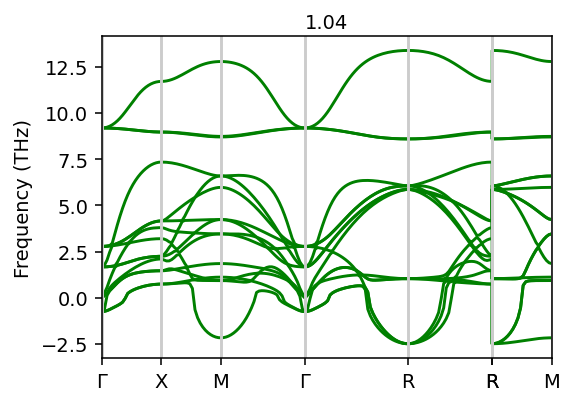

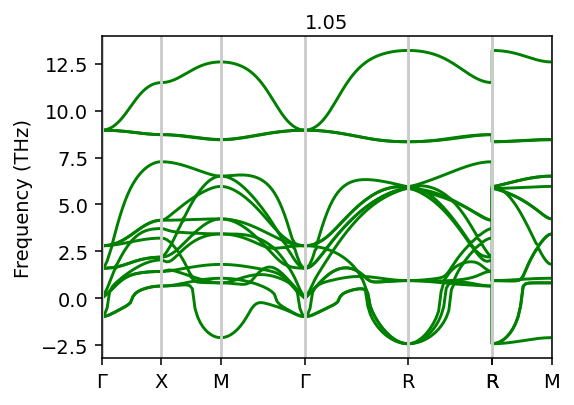

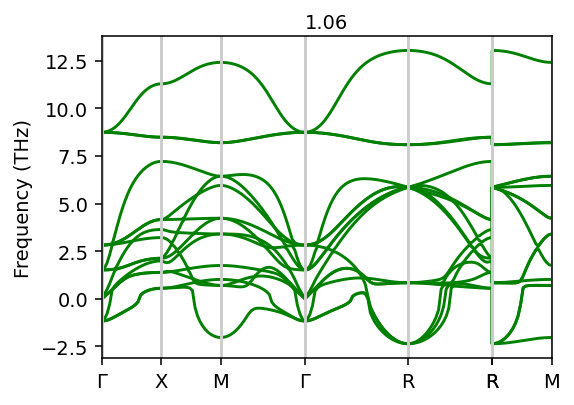

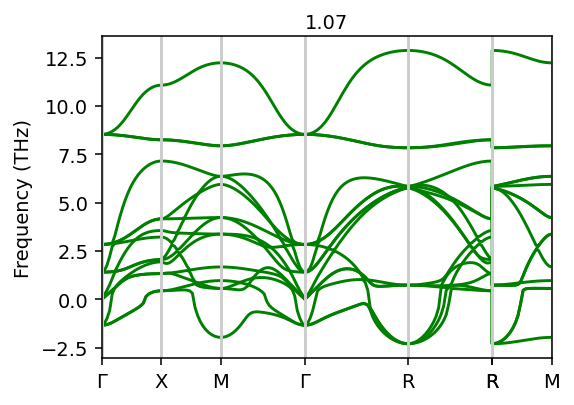

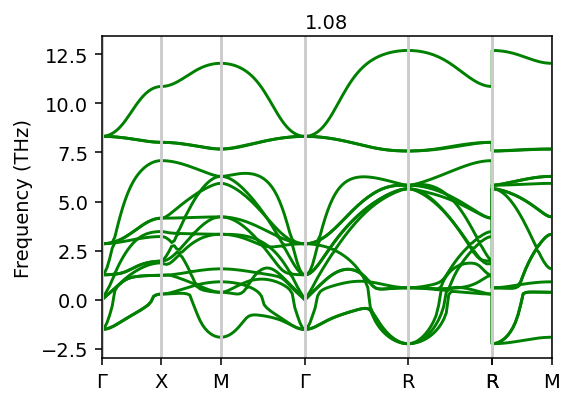

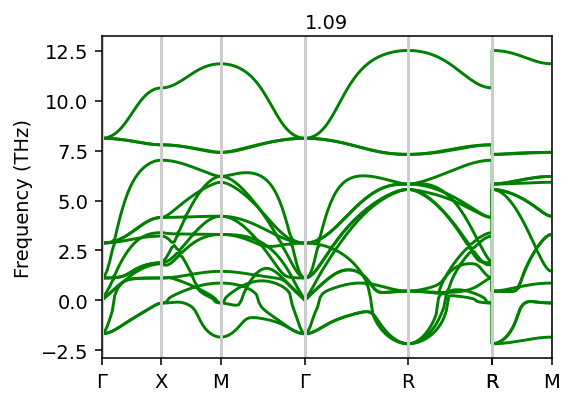

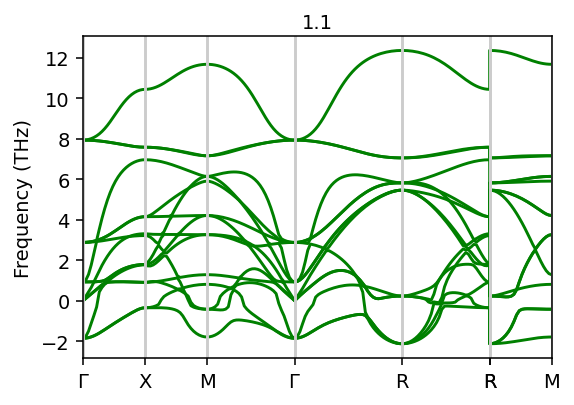

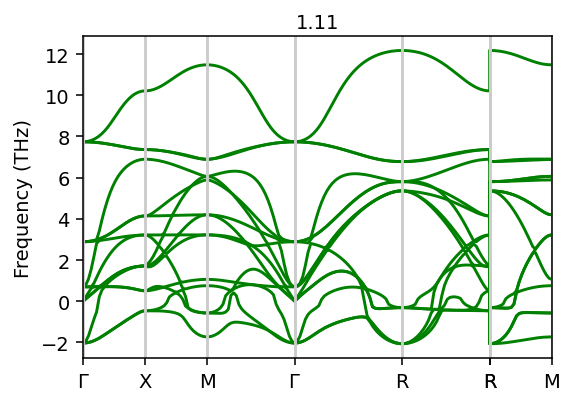

In [12]:
for volsc in np.arange(0.95, 1.11, 0.01):
    phonon = phonons['BaZrS3-spg221-Pm3m'][volsc]
    structure = get_structure(phonon)
    structure_tuple = (structure.cell[:], structure.get_scaled_positions(), structure.numbers)
    path = get_explicit_k_path(structure_tuple)
    phonon.run_band_structure([path['explicit_kpoints_rel']])
    band = phonon.get_band_structure_dict()
    df = DataFrame(band['frequencies'][0])
    df.index = path['explicit_kpoints_linearcoord']
    fig, ax = plt.subplots(figsize=(4.2, 3), dpi=140)

    for col in df.columns:
        ax.plot(df.index, df[col], color='green')
    ax.set_xlim(df.index.min(), df.index.max())
    ax.set_xlabel(volsc)
    ax.xaxis.set_label_position('top')
    ax.set_ylabel('Frequency (THz)')

# beautify the labels on the x-axis
    labels = path['explicit_kpoints_labels']
    labels = ['$\Gamma$' if m == 'GAMMA' else m for m in labels]
    labels = [m.replace('_', '$_') + '$' if '_' in m else m for m in labels]
    df_path = DataFrame(dict(labels=labels,
                         positions=path['explicit_kpoints_linearcoord']))
    df_path.drop(df_path.index[df_path.labels == ''], axis=0, inplace=True)
    ax.set_xticks(df_path.positions)
    ax.set_xticklabels(df_path.labels)
    for xp in df_path.positions:
        ax.axvline(xp, color='0.8')
    plt.tight_layout()